In [130]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from utils.save_and_load import load_naive_bayes_model, load_vectorizer, load_vector_model
from sentiment_model.svm import predict_svm
from sentiment_model import naiive_bayes
from sentiment_model.naiive_bayes import predict_naive_bayes
from sentiment_model.logistic_regression import log_predict


#### Part 1: Investigating Sentiment Model Performance

Best Logistic Regression:
regularization          L2
train_accuracy    0.792843
val_accuracy      0.757295
test_accuracy     0.749186
Name: 3, dtype: object

Best SVM:
regularization          L1
train_accuracy    0.683802
val_accuracy      0.680401
test_accuracy     0.681943
Name: 2, dtype: object

Best Naive Bayes:
regularization         NaN
train_accuracy    0.863941
val_accuracy      0.747151
test_accuracy     0.747934
Name: 0, dtype: float64



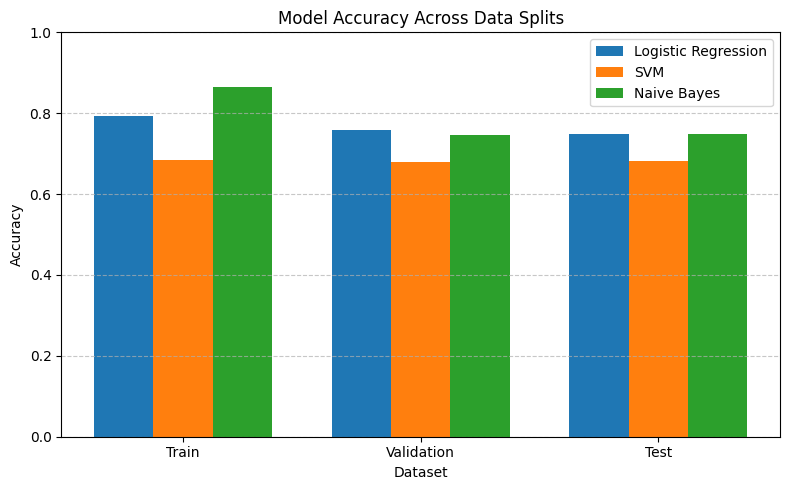

In [12]:
# Plotting train, test, and val accuracies. 
def load_best_accuracies(filepath, model_name):
    df = pd.read_csv(filepath)
    best_row = df.loc[df['val_accuracy'].idxmax()]

    train = best_row['train_accuracy']
    val = best_row['val_accuracy']
    test = best_row['test_accuracy']

    print(f"Best {model_name}:")
    print(best_row[['regularization', 'train_accuracy', 'val_accuracy', 'test_accuracy']])
    print()

    return [train, val, test]

def plot_all_accuracies_bar(log_reg, svm, nb): 
    sets = ['Train', 'Validation', 'Test']
    x = np.arange(len(sets))  # [0, 1, 2]
    width = 0.25  # Width of each bar

    plt.figure(figsize=(8, 5))

    # Bar positions for each model
    plt.bar(x - width, log_reg, width, label='Logistic Regression')
    plt.bar(x, svm, width, label='SVM')
    plt.bar(x + width, nb, width, label='Naive Bayes')

    # Axis formatting
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Across Data Splits')
    plt.xticks(x, sets)
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig("results/figs/model_accuracy_comparison_bar.png")
    plt.show()

# File paths
log_reg_path = "results/log_results_test.csv"
svm_path = "results/svm_results_test.csv"
nb_path = "results/nb_results_test.csv"

# Load accuracies
log_reg_accuracies = load_best_accuracies(log_reg_path, "Logistic Regression")
svm_accuracies = load_best_accuracies(svm_path, "SVM")
nb_accuracies = load_best_accuracies(nb_path, "Naive Bayes")

# Plot
plot_all_accuracies_bar(log_reg_accuracies, svm_accuracies, nb_accuracies)


#### Part 2: Predicting Sentiment of Twikit Scraped Tweets

In [126]:
# preprocess, remove @'s and special characters
test_tweets = pd.read_csv("data/neighborhood_tweets_nyc_final.csv")
test_tweets["tweet"] = (
       test_tweets["tweet"]
        .str.replace(r"@\w+", "", regex=True)
        .str.lower()
        .str.strip()
    )

# Remove any NaNs, convert to str
test_tweets = test_tweets.dropna(subset=["tweet", "neighborhood"])
test_tweets["tweet"] = test_tweets["tweet"].astype(str)

assert test_tweets["tweet"].isnull().sum() == 0, "tweets still contain NaNs!"

print(test_tweets.shape)
print(test_tweets)

(1553, 2)
               neighborhood                                              tweet
0     borough park brooklyn  kushner\n\nfeb 18 - brooklyn incident\n-betar ...
1     borough park brooklyn  i'm 100% brooklyn. 50% borough park. 50% crown...
2     borough park brooklyn  the huge gap between the nose and upper lip.\n...
3     borough park brooklyn  the video you're referring to was filmed in br...
4     borough park brooklyn  april 13, 2025 - fdny on the scene of a all-ha...
...                     ...                                                ...
1548       rockaways queens  headless, armless body found on beach in rocka...
1549       rockaways queens  headless, armless body found on beach in rocka...
1550       rockaways queens  a headless, armless body was found lying on th...
1551       rockaways queens  we joined queens community justice center rock...
1552       rockaways queens             fort tilden beach/rockaways/queens/nyc

[1553 rows x 2 columns]


In [128]:
# Table 1 in paper
tweet_counts = test_tweets['neighborhood'].value_counts().sort_values(ascending=False)
tweet_counts


neighborhood
sunset park brooklyn         193
flatbush brooklyn            189
bushwick brooklyn            183
astoria queens               175
borough park brooklyn        174
central harlem manhattan     169
rockaways queens             168
coney island brooklyn        167
upper east side manhattan    135
Name: count, dtype: int64

In [129]:
# add sentiment labels fro all models
def predict_on_unseen(model_type, df):
    df["tweet"] = df["tweet"].astype(str)

    if model_type in ["log", "svm"]:
        vectorizer = load_vectorizer()
        X = vectorizer.transform(df["tweet"])
        weights = load_vector_model(model_type)

        if model_type == "log":
            preds = log_predict(X, weights)
        else:
            preds = predict_svm(X, weights)

    elif model_type == "nb":
        load_naive_bayes_model(naiive_bayes)
        preds = [predict_naive_bayes(text) for text in df["tweet"]]

    df[f"predicted_sentiment_from_{model_type}"] = preds
    return df

# predict svm 
df = predict_on_unseen("svm", test_tweets)

# predih naive bayes 
df = predict_on_unseen("nb", test_tweets)


# predict log regress 
df = predict_on_unseen("log", test_tweets)

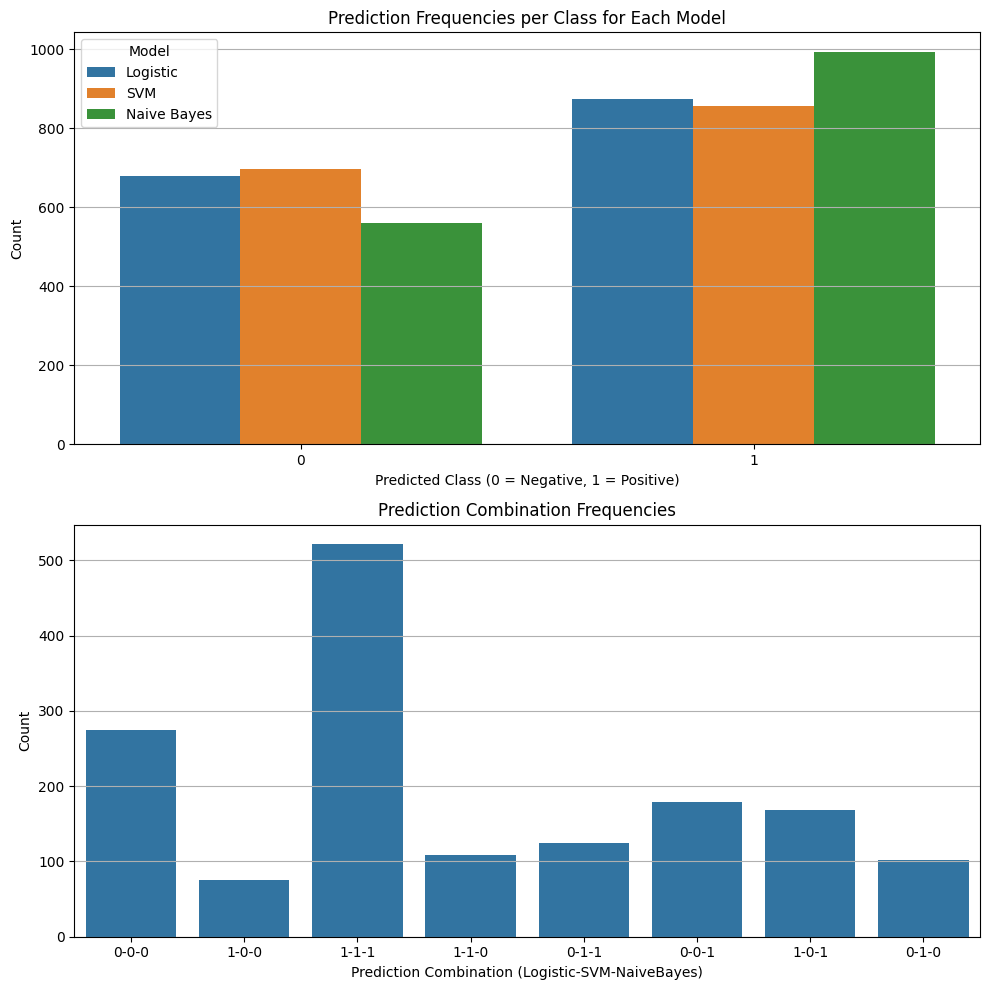

In [132]:
# Figure 6a and b in paper
# Rename for plotting
df_plot = df.rename(columns={
    'predicted_sentiment_from_log': 'Logistic',
    'predicted_sentiment_from_svm': 'SVM',
    'predicted_sentiment_from_nb': 'Naive Bayes'
})

# Melt the DataFrame
df_melt = df_plot.melt(value_vars=['Logistic', 'SVM', 'Naive Bayes'],
                       var_name='Model', value_name='Prediction')

# Create combination column
df['combo'] = df[['predicted_sentiment_from_log', 'predicted_sentiment_from_svm', 'predicted_sentiment_from_nb']].astype(str).agg('-'.join, axis=1)

# Plot stacked subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=False)

# Top subplot: prediction frequencies
sns.countplot(data=df_melt, x='Prediction', hue='Model', ax=axs[0])
axs[0].set_title('Prediction Frequencies per Class for Each Model')
axs[0].set_xlabel('Predicted Class (0 = Negative, 1 = Positive)')
axs[0].set_ylabel('Count')
axs[0].legend(title='Model')
axs[0].grid(True, axis='y')

# Bottom subplot: prediction combinations
sns.countplot(x='combo', data=df, ax=axs[1])
axs[1].set_title('Prediction Combination Frequencies')
axs[1].set_xlabel('Prediction Combination (Logistic-SVM-NaiveBayes)')
axs[1].set_ylabel('Count')
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

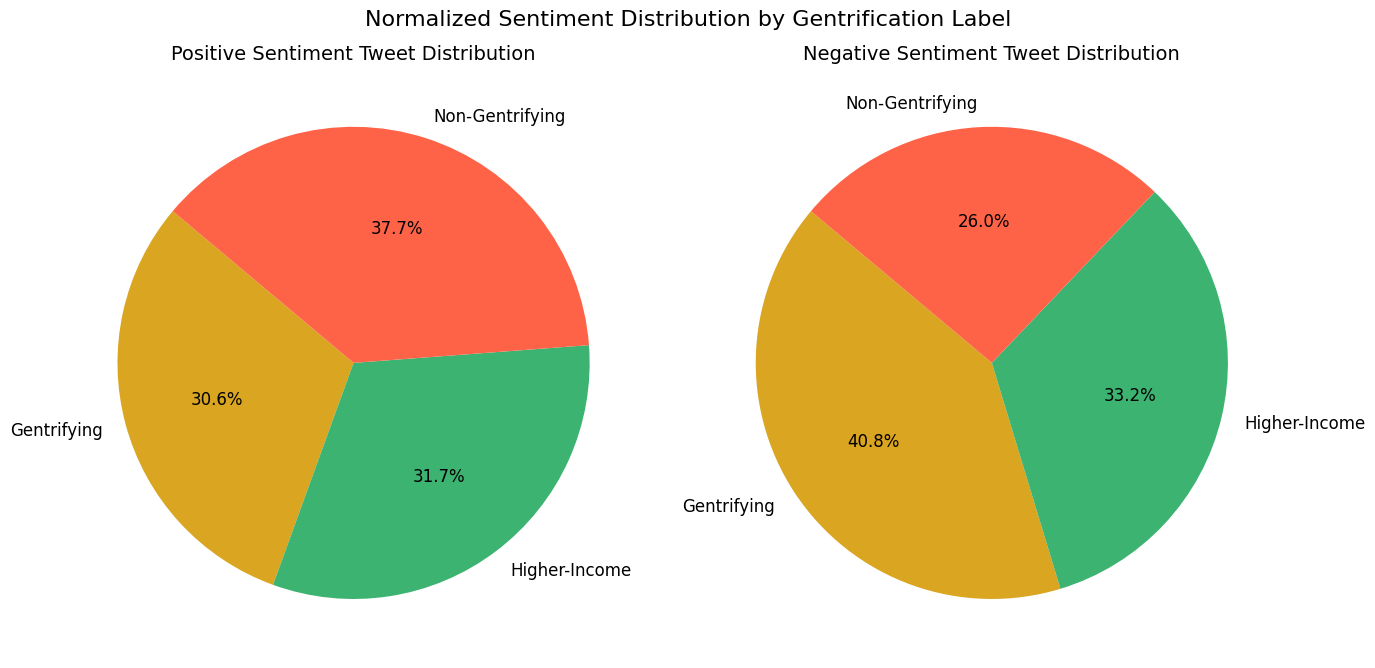

In [115]:
import matplotlib.pyplot as plt

# Step 1: Split the DataFrame by sentiment
pos_df = df[df['predicted_sentiment_from_svm'] == 1]
neg_df = df[df['predicted_sentiment_from_svm'] == 0]

# Step 2: Count gentrification labels
pos_counts = pos_df['gentrification_label'].value_counts(normalize=True).sort_index()
neg_counts = neg_df['gentrification_label'].value_counts(normalize=True).sort_index()

# Step 3: Standardize label order and define colors
labels = sorted(set(df['gentrification_label']))
color_map = {
    'Gentrifying': 'goldenrod',
    'Higher-Income': 'mediumseagreen',
    'Non-Gentrifying': 'tomato'
}
colors = [color_map[label] for label in labels]

# Step 4: Plot side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Positive sentiment pie
axes[0].pie(
    [pos_counts.get(label, 0) for label in labels],
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
axes[0].set_title('Positive Sentiment Tweet Distribution', fontsize=14)

# Negative sentiment pie
axes[1].pie(
    [neg_counts.get(label, 0) for label in labels],
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
axes[1].set_title('Negative Sentiment Tweet Distribution', fontsize=14)

plt.suptitle('Normalized Sentiment Distribution by Gentrification Label', fontsize=16)
plt.tight_layout()
plt.show()



In [124]:

import pandas as pd
import scipy.stats as stats
import numpy as np

# Create contingency table
contingency_log = pd.crosstab(df['predicted_sentiment_from_log'], df['gentrification_label'])
contingency_svm = pd.crosstab(df['predicted_sentiment_from_svm'], df['gentrification_label'])
contingency_nb = pd.crosstab(df['predicted_sentiment_from_nb'], df['gentrification_label'])

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Chi-square test
chi2_log, p_log, dof_log, expected_log = stats.chi2_contingency(contingency_log)
chi2_svm, p_svm, dof_svm, expected_svm = stats.chi2_contingency(contingency_svm)
chi2_nb, p_nb, dof_nb, expected_nb = stats.chi2_contingency(contingency_log)
v_log = cramers_v(contingency_log)
v_svm = cramers_v(contingency_svm)
v_nb = cramers_v(contingency_nb)



print("Chi-Square Test for Log")
print("===============")
print(f"Chi2 statistic: {chi2_log:.2f}")
print(f"Degrees of freedom: {dof_log}")
print(f"P-value: {p_log:.7f}")
print(f"Cramér's V: {v_log:.4f}")
print()

print("Chi-Square Test for SVM")
print("===============")
print(f"Chi2 statistic: {chi2_svm:.2f}")
print(f"Degrees of freedom: {dof_svm}")
print(f"P-value: {p_svm:.7f}")
print(f"Cramér's V: {v_svm:.4f}")
print()

print("Chi-Square Test for NB")
print("===============")
print(f"Chi2 statistic: {chi2_nb:.2f}")
print(f"Degrees of freedom: {dof_nb}")
print(f"P-value: {p_nb:.7f}")
print(f"Cramér's V: {v_nb:.4f}")










Chi-Square Test for Log
Chi2 statistic: 33.13
Degrees of freedom: 2
P-value: 0.0000001
Cramér's V: 0.1460

Chi-Square Test for SVM
Chi2 statistic: 27.84
Degrees of freedom: 2
P-value: 0.0000009
Cramér's V: 0.1339

Chi-Square Test for NB
Chi2 statistic: 33.13
Degrees of freedom: 2
P-value: 0.0000001
Cramér's V: 0.1703


#### Other Visualizations not included in Paper

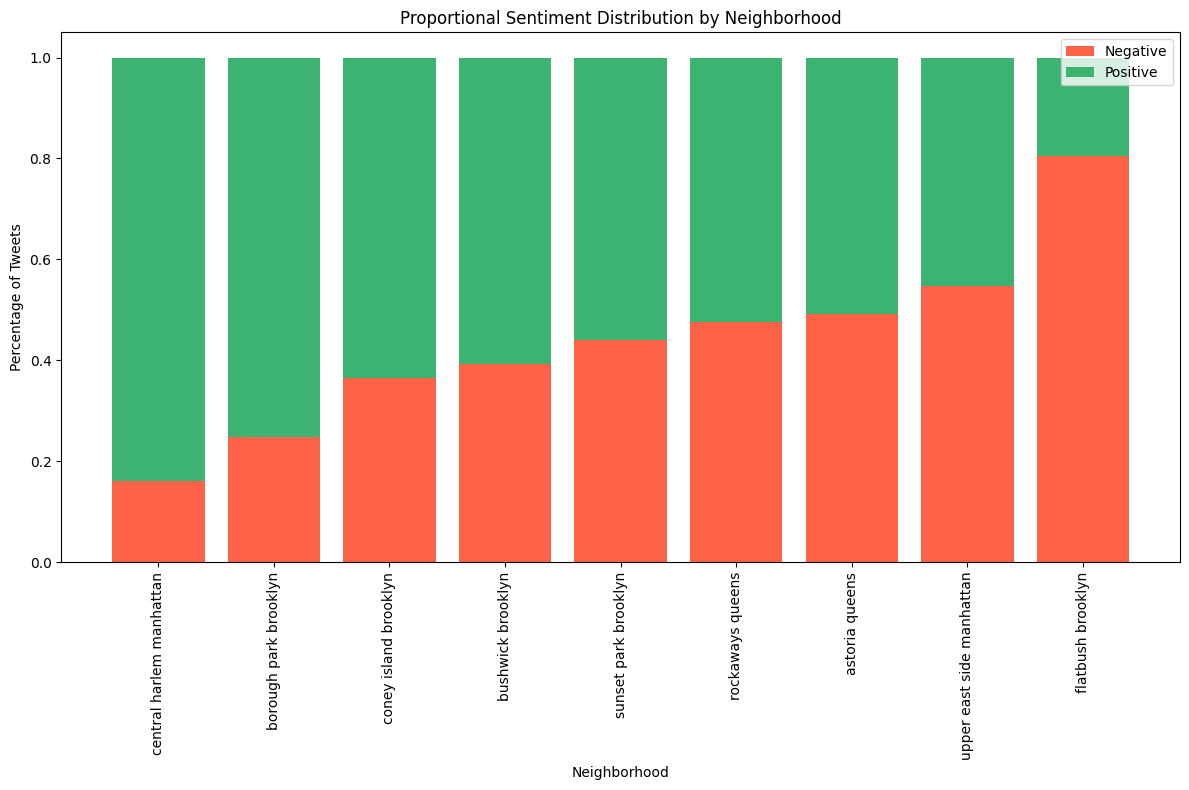

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Group by neighborhood and sentiment, count tweets
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Group by neighborhood and sentiment
sentiment_counts = df.groupby(['neighborhood', 'predicted_sentiment_from_log']).size().unstack(fill_value=0)

# Step 2: Convert counts to percentages
sentiment_percent = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Step 3: Sort by positive sentiment percentage (optional)
sentiment_percent = sentiment_percent.sort_values(by=1, ascending=False)

# Step 4: Plot stacked percentage bar chart
plt.figure(figsize=(12, 8))

# Bottom = % of negative (0)
plt.bar(sentiment_percent.index, sentiment_percent[0], label='Negative', color='tomato')

# Top = % of positive (1), stacked
plt.bar(sentiment_percent.index, sentiment_percent[1], bottom=sentiment_percent[0], label='Positive', color='mediumseagreen')

plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Percentage of Tweets')
plt.title('Proportional Sentiment Distribution by Neighborhood')
plt.legend()
plt.tight_layout()
plt.show()




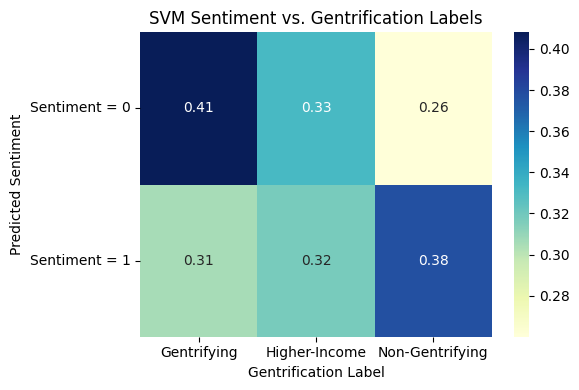

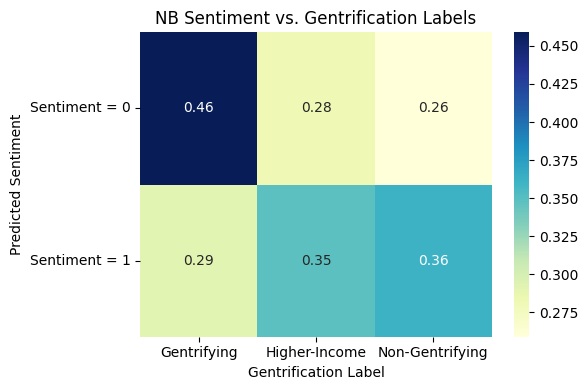

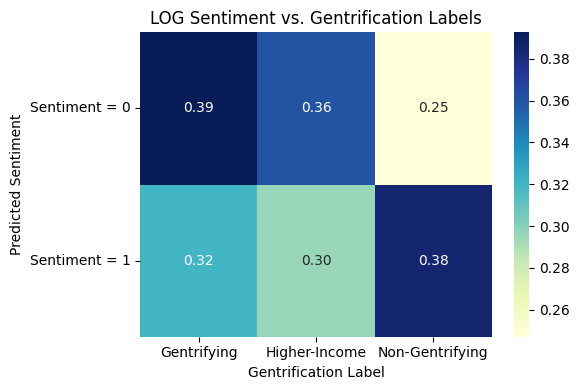

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# One-hot encode gentrification labels
gentrification_onehot = pd.get_dummies(df['gentrification_label'])

# Loop through each model
models = ['svm', 'nb', 'log']
for model in models:
    sentiment_col = f'predicted_sentiment_from_{model}'
    
    # Group by sentiment (0 or 1) and calculate mean for each label
    sentiment_vs_gentrification = df[[sentiment_col]].join(gentrification_onehot)
    grouped = sentiment_vs_gentrification.groupby(sentiment_col).mean()

    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(grouped, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title(f'{model.upper()} Sentiment vs. Gentrification Labels')
    plt.xlabel('Gentrification Label')
    plt.ylabel('Predicted Sentiment')
    plt.yticks([0.5, 1.5], ['Sentiment = 0', 'Sentiment = 1'], rotation=0)
    plt.tight_layout()
    plt.show()
